<a href="https://colab.research.google.com/github/Trantracy/Cat-and-dog-classification/blob/master/Tran_Cat_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KITTEN or PUPPY? 
![image.png]()![image.png](attachment:image.png)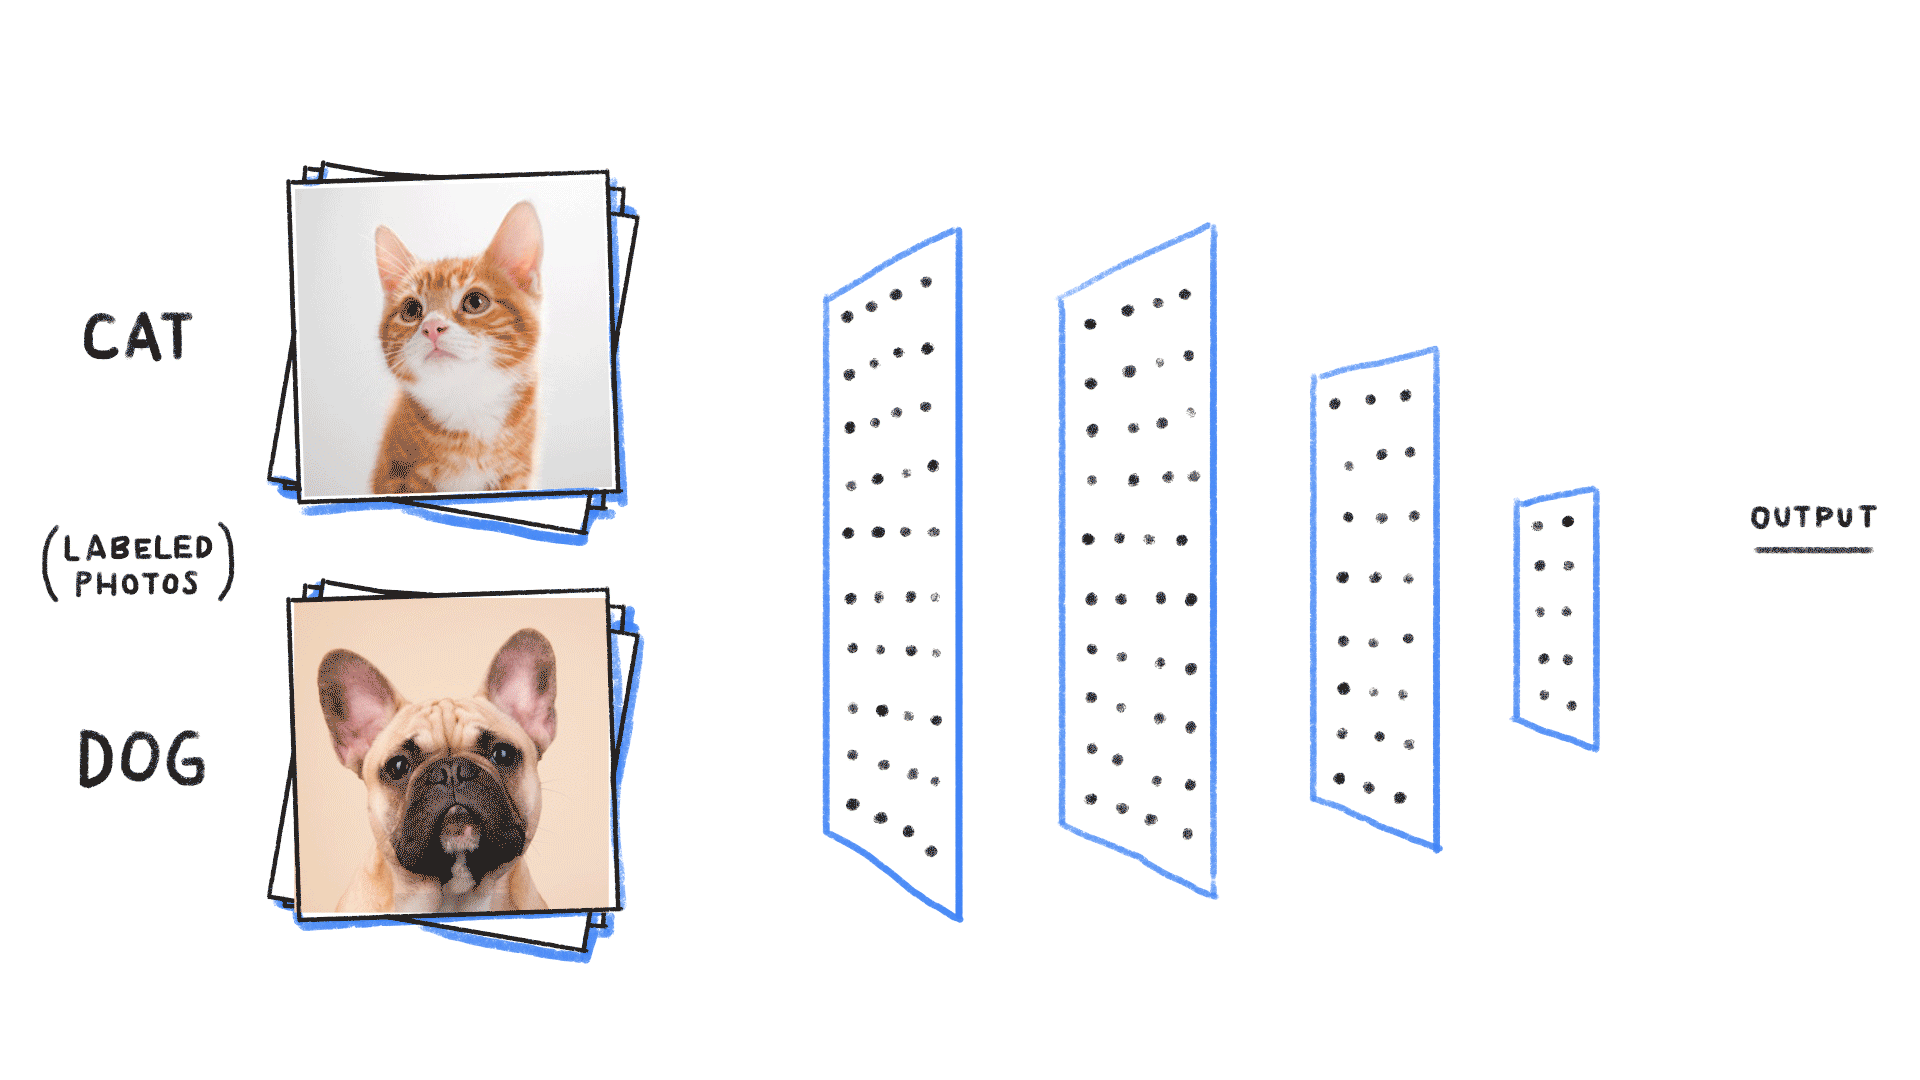

In [0]:
# Import libaries
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import os 
import cv2
import time

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Activation
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Import the train set and test set

In [0]:
# Path to train & test data
train_dir = './train/'
test_dir = './test1/'

# All image paths 
train_data_path = [train_dir + file_name for file_name in os.listdir(train_dir)]
#train_data_path = [os.path.join(train_dir, file_name) for file_name in os.listdir(train_dir)]

### Plot some picture:

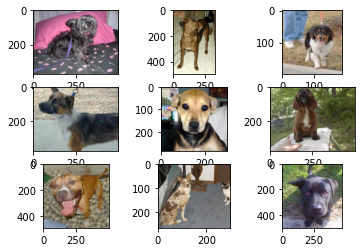

In [0]:
# plot dog photos from the dogs vs cats dataset
import matplotlib.pyplot as plt 
from matplotlib.image import imread
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = train_dir + 'dog.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

## Data preprocessing

In [0]:
# Decode into (w,h,c) and rezize and normalize
IMAGE_SIZE = 224

# Preprocess an image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0

    return image

# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

### Create a pipeline by data.Dataset

In [0]:
# AUTOTUNE to set the parameters dynamically based on available CPU
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Create dataset from image paths
path_dataset = tf.data.Dataset.from_tensor_slices(train_data_path)

# Create image dataset from path dataset
image_dataset = path_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [0]:
#  Labeling the Data 0 and 1
def label_image(path):
    image_label_list = []
    for i in os.listdir(path): 
        img_name = i.split(".")[0]
        if img_name == "cat":
            image_label_list.append(1)
        else:
            image_label_list.append(0)
    return image_label_list
image_label = label_image(train_dir)
#  Generate image labels
# image_label = list(map(lambda x: 1 if x.split('.')[0] == 'cat' else 0, os.listdir(train_dir)))

In [0]:
# Create image label dataset
# tf.cast creates a new tensor with the specified data type and does not alter the original variable. 
label_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(image_label, tf.int16))

In [0]:
# Combine image dataset and image label dataset
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

In [0]:
# Split train, test and validation set
DATASET_SIZE = 25000
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 4096

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

dataset = dataset.shuffle(buffer_size = SHUFFLE_BUFFER_SIZE)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [0]:
# Perform mini-batch in train_dataset and test_dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

## Train model

## Model 1: Using pre-train model VGG16

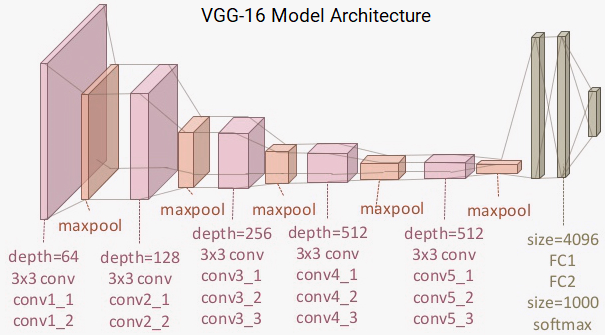

The VGG-16 model is a 16-layer (convolution and fully connected) network built on the ImageNet database. VGG16 is using 3 x 3 convolution filters along with max pooling layers for downsampling.
We will be using our own fully connected dense layers for the last three layers to predict whether images will be a dog or a cat.

In [0]:
# Fetch a copy of VGG16 from tf.keras.applications
base_model = tf.keras.applications.VGG16 (weights = 'imagenet',
                   include_top = False,
                   input_shape =(224,224,3))
base_model.trainable = False

# Tranfer-learning
def transfer_learning():
    
    model = tf.keras.Sequential([
                            base_model,
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(256,activation = "relu"),
                            tf.keras.layers.Dense(1,activation = 'sigmoid')])



    model.compile(loss='binary_crossentropy',
                  optimizer =tf.keras.optimizers.RMSprop(lr  = 2e-5),
                  metrics =['accuracy'])
        
    return model

model = transfer_learning()


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# Saving the epoch with checkpoint
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# by default it saves the weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
# Train model
model_history = model.fit(train_dataset, epochs = 50, validation_data = val_dataset, callbacks=[cp_callback])

Train for 136 steps, validate for 29 steps
Epoch 1/50
135/136 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.8216
Epoch 00001: saving model to training/cp.ckpt
136/136 [==============================] - 117s 860ms/step - loss: 0.3912 - accuracy: 0.8221 - val_loss: 0.2439 - val_accuracy: 0.8987
Epoch 2/50
135/136 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.8978
Epoch 00002: saving model to training/cp.ckpt
136/136 [==============================] - 40s 298ms/step - loss: 0.2449 - accuracy: 0.8980 - val_loss: 0.2091 - val_accuracy: 0.9146
Epoch 3/50
135/136 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9142
Epoch 00003: saving model to training/cp.ckpt
136/136 [==============================] - 40s 291ms/step - loss: 0.2080 - accuracy: 0.9139 - val_loss: 0.1816 - val_accuracy: 0.9281
Epoch 4/50
135/136 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9241
Epoch 00004: saving model to tra

In [0]:
# Evaluate model
model.evaluate(test_dataset)

29/29 [==============================] - 12s 407ms/step - loss: 0.1244 - accuracy: 0.9564


[0.12437044668557315, 0.9563578]

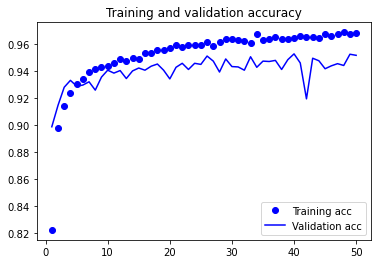

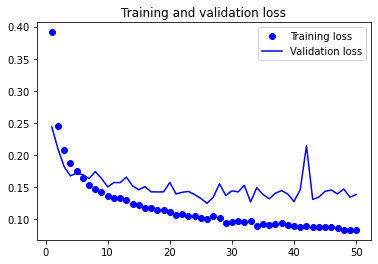

In [0]:
# Visualize model history
def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_accuracy_and_loss(model_history)

In [0]:
# save model
model.save('model.h5')

- The model is overfit and the performance is not good in training set and validation set. 
- For the test set's accuracy: 0.9564 and loss: 0.1244 

## Improve performance:

### Using data Augmentation:
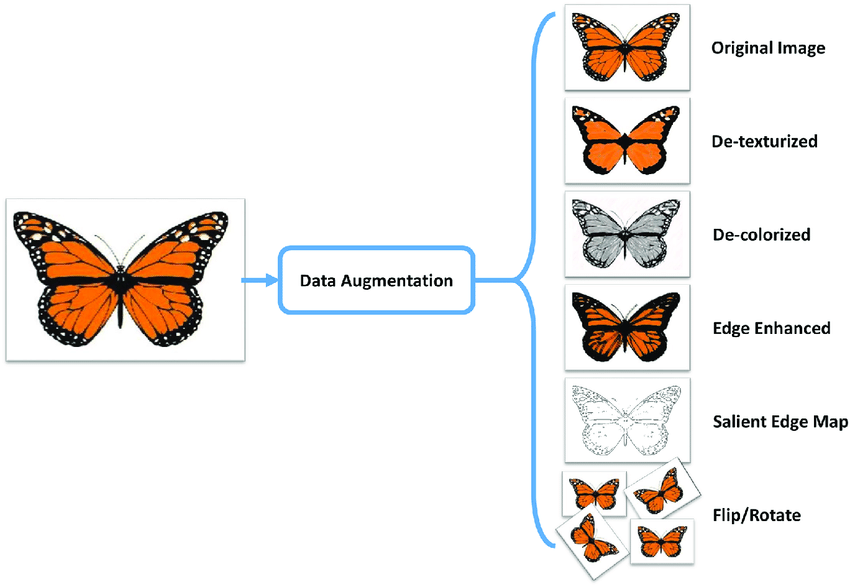![image.png](attachment:image.png)

The ImageDataGenerator in Keras has three methods to read the images from a big numpy array and folders containing images.

1. flow()
2. flow_from_directory() 
3. flow_from_dataframe()

In this project, I use flow_from_directory() for the sake of ease. 
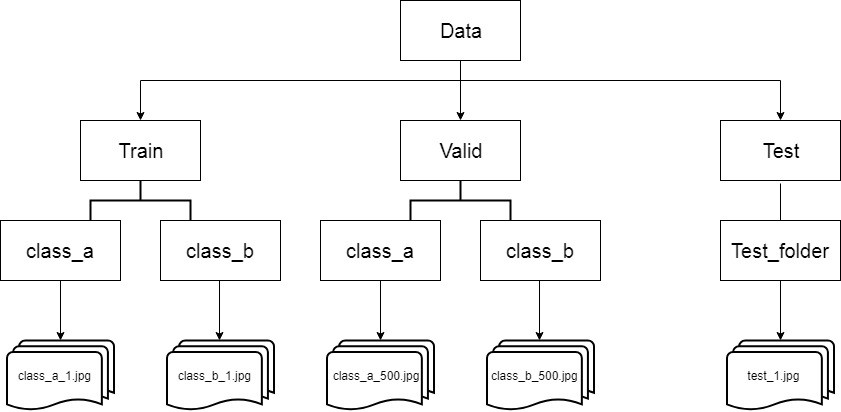

### Create the folders cats and dogs for train set, validation set and test set:

In [0]:
import os, shutil
# create directories
base_dir = 'dogs-vs-cats/'
subdirs = ['train/', 'validation/', 'test/']
for subdir in subdirs:
# create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = base_dir + subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [0]:
original_dataset_dir = 'train/'

fnames = ['cat.{}.jpg'.format(i) for i in range(8000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(8000, 10250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(10250, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(8000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(8000, 10250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(10250, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
total_training = len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir))
print('total training images:', total_training)
print()

print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
total_validation = len(os.listdir(validation_cats_dir)) + len(os.listdir(validation_dogs_dir))
print('total validation images:', total_validation)
print()

print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))
print('total test images:', len(os.listdir(test_cats_dir)) + len(os.listdir(test_dogs_dir)))
print()

total training cat images: 8002
total training dog images: 8000
total training images: 16002

total validation cat images: 2250
total validation dog images: 2250
total validation images: 4500

total test cat images: 2251
total test dog images: 2251
total test images: 4502



### Training model and visualization:

In [0]:
# Tranfer-learning
def transfer_learning():
    
    model = tf.keras.Sequential([
                            base_model,
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(256,activation = "relu"),
                            tf.keras.layers.Dropout(0.5),        
                            tf.keras.layers.Dense(1,activation = 'sigmoid')])
                                                  

    model.compile(loss='binary_crossentropy',
                  optimizer =tf.keras.optimizers.RMSprop(lr  = 2e-5),
                  metrics =['accuracy'])
        
    return model
        
model = transfer_learning()

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 32
# The list of classes will be automatically inferred from the subdirectory names/structure under train_dir
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resize all images to 224 x 224
    batch_size= batch_size,
    class_mode='binary') # because we use binary_crossentropy loss we need binary labels

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224), # resize all images to 224 x 224
    batch_size= batch_size,
    class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.


In [0]:
# Saving the epoch with checkpoint
checkpoint_path = "training2/cp_data_aug.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# by default it saves the weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
# Train the model
steps_per_epoch = tf.math.ceil(total_training/batch_size).numpy()
validation_steps = tf.math.ceil(total_validation/batch_size).numpy()

history = model.fit_generator(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs = 50,
    validation_data= validation_generator,
    validation_steps=validation_steps, 
    callbacks=[cp_callback])  # Pass callback to training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500.0 steps, validate for 141.0 steps
Epoch 1/50
499/500 [============================>.] - ETA: 0s - loss: 1.7742 - accuracy: 0.8947
Epoch 00001: saving model to training2/cp_data_aug.ckpt
500/500 [==============================] - 64s 128ms/step - loss: 1.7729 - accuracy: 0.8947 - val_loss: 0.2403 - val_accuracy: 0.9736
Epoch 2/50
499/500 [============================>.] - ETA: 0s - loss: 0.5811 - accuracy: 0.9543
Epoch 00002: saving model to training2/cp_data_aug.ckpt
500/500 [==============================] - 63s 125ms/step - loss: 0.5799 - accuracy: 0.9544 - val_loss: 0.2168 - val_accuracy: 0.9758
Epoch 3/50
499/500 [============================>.] - ETA: 0s - loss: 0.4858 - accuracy: 0.9611
Epoch 00003: saving model to training2/cp_data_aug.ckpt
500/500 [==============================] - 63s 126ms/step - loss: 0.4848 - accuracy: 0.9612 - val_loss: 0.1735 - val_accuracy: 0.9791
Epoch 4/50
499/500 [========================

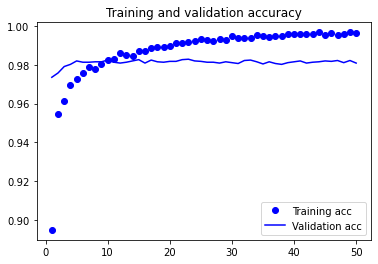

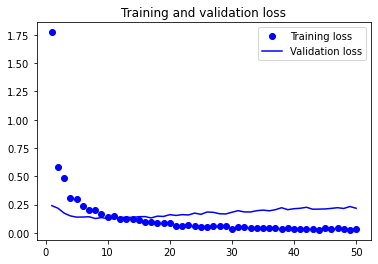

In [0]:
# Visual the model:
plot_accuracy_and_loss(history)

The model seems to be overfitting, Let's do fine-tuning to handle this problem

In [0]:
# Evaluate model
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

model.evaluate(test_generator, steps=50)

Found 4500 images belonging to 2 classes.
  ...
    to  
  ['...']
50/50 [==============================] - 8s 160ms/step - loss: 0.1542 - accuracy: 0.9856


[0.1541976740026478, 0.9856]

In [0]:
# save data augmentation model
model.save('model_data_aug.h5')

## Fine-tuning model

- Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (the fully-connected classifier) and these top layers.
    This project will fine-tune the last 3 convolutional layers and block 5, which means that all layers up until block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable.
- Another techniques applied: Weight Regularization L2, early-stopping, learning rate decay to decrease the overfitting

![image.png](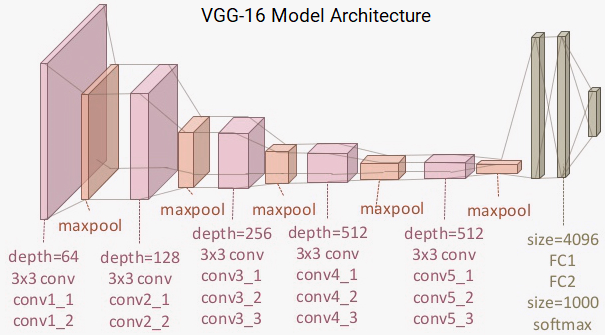
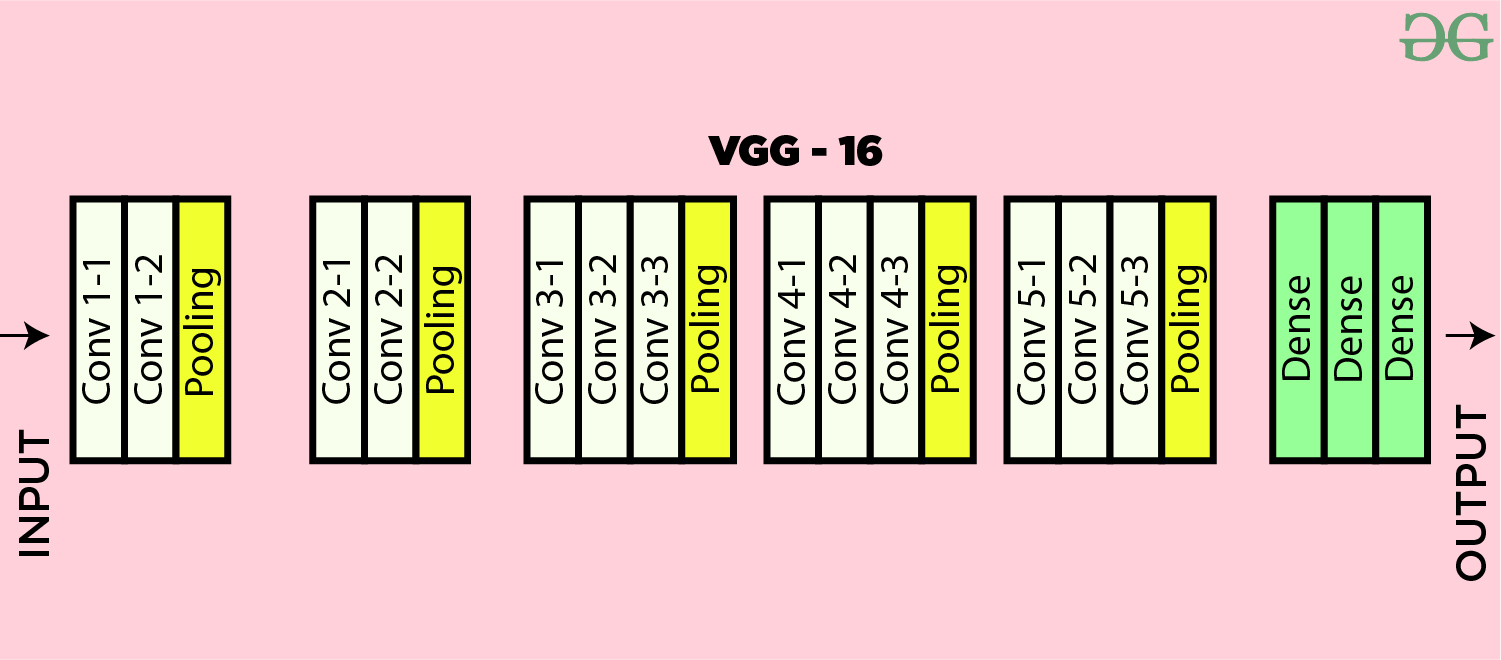

In [0]:
# Fetch a copy of VGG16 from tf.keras.applications
conv_base = tf.keras.applications.VGG16 (weights = 'imagenet',
                   include_top = False,
                   input_shape =(224,224,3))
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
# Tranfer-learning
def transfer_learning():
    
    last_model = tf.keras.Sequential([
                            conv_base,
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(256,activation = "relu", kernel_regularizer=regularizers.l2(0.001)),
                            tf.keras.layers.Dropout(0.5),        
                            tf.keras.layers.Dense(1,activation = 'sigmoid')])
                                                  
    last_model.compile(loss='binary_crossentropy',
                  optimizer =tf.keras.optimizers.Adam(lr  = 2e-5),
                  metrics =['accuracy'])
        
    return last_model

        
last_model = transfer_learning()

In [0]:
# Set callback functions to early stop training and save the best model so far
call_back = [EarlyStopping(monitor='val_loss', patience= 2), # the number of epochs without improvement you allow before training should be aborted
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [0]:
# Train model
last_history = last_model.fit_generator(train_generator,
                                       steps_per_epoch= steps_per_epoch,
                                       epochs = 50,
                                       validation_data= validation_generator,
                                       validation_steps=validation_steps, 
                                       callbacks=call_back)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500.0 steps, validate for 141.0 steps
Epoch 1/50
500/500 [==============================] - 66s 133ms/step - loss: 1.2752 - accuracy: 0.8962 - val_loss: 0.5506 - val_accuracy: 0.9729
Epoch 2/50
500/500 [==============================] - 65s 131ms/step - loss: 0.5892 - accuracy: 0.9606 - val_loss: 0.5265 - val_accuracy: 0.9780
Epoch 3/50
500/500 [==============================] - 65s 130ms/step - loss: 0.5395 - accuracy: 0.9737 - val_loss: 0.5072 - val_accuracy: 0.9807
Epoch 4/50
500/500 [==============================] - 66s 132ms/step - loss: 0.4992 - accuracy: 0.9827 - val_loss: 0.5051 - val_accuracy: 0.9807
Epoch 5/50
500/500 [==============================] - 66s 132ms/step - loss: 0.4746 - accuracy: 0.9872 - val_loss: 0.4783 - val_accuracy: 0.9844
Epoch 6/50
500/500 [==============================] - 66s 132ms/step - loss: 0.4587 - accuracy: 0.9898 - val_loss: 0.4694 - val_accuracy: 0.9833
Epoch 7/50
500/500 [============

In [0]:
# Evaluate model
last_model.evaluate_generator(test_generator, steps=50)

  ...
    to  
  ['...']


[0.1206289279460907, 0.992]

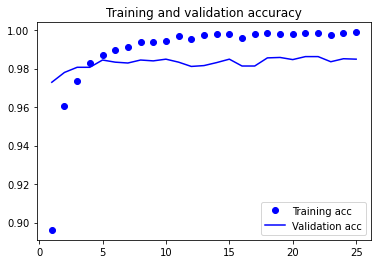

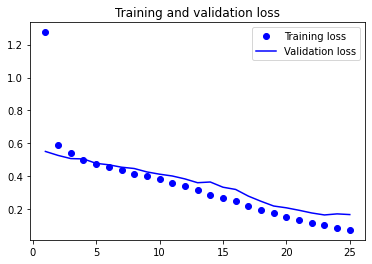

In [0]:
# Visual the model:
plot_accuracy_and_loss(last_history)

In [0]:
# save model: 
last_model.save('model_fine_tune.h5')

## Model with SGD Optimizer and learning rate decay:

In [0]:
# Create ReduceLROnPlateau Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                              patience=7, min_delta=1e-4, mode='max')

In [0]:
# Set callback functions to early stop training and save the best model so far
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10)
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='lr_SGD_model.h5', monitor='val_loss', save_best_only=True)

In [0]:
# With learning rate decay
def transfer():
    SGD_model = tf.keras.Sequential([
                            conv_base,
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(256,activation = "relu", kernel_regularizer=regularizers.l2(0.001)),
                            tf.keras.layers.Dropout(0.5),        
                            tf.keras.layers.Dense(1,activation = 'sigmoid')])
    
    sgd = tf.keras.optimizers.SGD(lr=2e-5, decay=1e-6, momentum=0.9, nesterov=True)
    SGD_model.compile(optimizer=sgd,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return SGD_model

SGD_model = transfer()

In [0]:
SGD_history = SGD_model.fit_generator(train_generator,
                                       steps_per_epoch= steps_per_epoch,
                                       epochs = 50,
                                       validation_data= validation_generator,
                                       validation_steps=validation_steps, 
                                       callbacks=[ModelCheckpoint, reduce_lr, EarlyStopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500.0 steps, validate for 141.0 steps
Epoch 1/50
500/500 [==============================] - 66s 131ms/step - loss: 0.6374 - accuracy: 0.9757 - val_loss: 0.5557 - val_accuracy: 0.9847
Epoch 2/50
500/500 [==============================] - 63s 126ms/step - loss: 0.5281 - accuracy: 0.9926 - val_loss: 0.5625 - val_accuracy: 0.9860
Epoch 3/50
500/500 [==============================] - 62s 124ms/step - loss: 0.5213 - accuracy: 0.9946 - val_loss: 0.5604 - val_accuracy: 0.9856
Epoch 4/50
500/500 [==============================] - 62s 124ms/step - loss: 0.5189 - accuracy: 0.9950 - val_loss: 0.5622 - val_accuracy: 0.9858
Epoch 5/50
500/500 [==============================] - 62s 124ms/step - loss: 0.5170 - accuracy: 0.9964 - val_loss: 0.5636 - val_accuracy: 0.9864
Epoch 6/50
500/500 [==============================] - 61s 122ms/step - loss: 0.5131 - accuracy: 0.9974 - val_loss: 0.5638 - val_accuracy: 0.9864
Epoch 7/50
500/500 [============

In [0]:
# Evaluate model
SGD_model.evaluate_generator(test_generator, steps=50)

  ...
    to  
  ['...']


[0.5511623895168305, 0.9908]

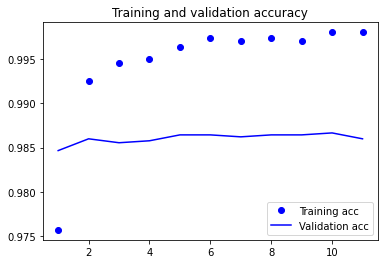

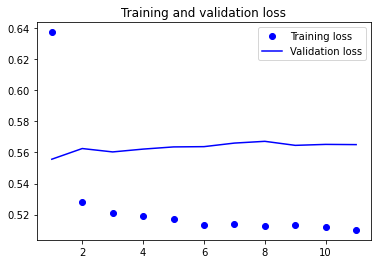

In [0]:
# Visual the model:
plot_accuracy_and_loss(SGD_history)

In [0]:
# save model: 
SGD_model.save('SGD_model.h5')

## ADAM + learning rate

In [0]:
# With learning rate decay
def transferAdam():
    Adam_model = tf.keras.Sequential([
                            conv_base,
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(256,activation = "relu", kernel_regularizer=regularizers.l2(0.001)),
                            tf.keras.layers.Dropout(0.5),        
                            tf.keras.layers.Dense(1,activation = 'sigmoid')])
    
    adam = tf.keras.optimizers.Adam(lr  = 2e-5)
    Adam_model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return Adam_model

Adam_model = transferAdam()

In [0]:
Adam_history = Adam_model.fit_generator(train_generator,
                                       steps_per_epoch= steps_per_epoch,
                                       epochs = 50,
                                       validation_data= validation_generator,
                                       validation_steps=validation_steps, 
                                       callbacks=[ModelCheckpoint, reduce_lr, EarlyStopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500.0 steps, validate for 141.0 steps
Epoch 1/50
500/500 [==============================] - 63s 127ms/step - loss: 1.1857 - accuracy: 0.9121 - val_loss: 0.5522 - val_accuracy: 0.9747
Epoch 2/50
500/500 [==============================] - 62s 124ms/step - loss: 0.5972 - accuracy: 0.9653 - val_loss: 0.5242 - val_accuracy: 0.9791
Epoch 3/50
500/500 [==============================] - 62s 124ms/step - loss: 0.5326 - accuracy: 0.9791 - val_loss: 0.5171 - val_accuracy: 0.9807
Epoch 4/50
500/500 [==============================] - 62s 124ms/step - loss: 0.4979 - accuracy: 0.9844 - val_loss: 0.5058 - val_accuracy: 0.9849
Epoch 5/50
500/500 [==============================] - 61s 122ms/step - loss: 0.4805 - accuracy: 0.9874 - val_loss: 0.4876 - val_accuracy: 0.9860
Epoch 6/50
500/500 [==============================] - 61s 122ms/step - loss: 0.4653 - accuracy: 0.9889 - val_loss: 0.4744 - val_accuracy: 0.9831
Epoch 7/50
500/500 [============

In [0]:
# Evaluate model
Adam_model.evaluate_generator(test_generator, steps=50)

  ...
    to  
  ['...']


[0.3510981249809265, 0.9916]

In [0]:
# Visual the model:
plot_accuracy_and_loss(Adam_history)

In [0]:
# save model: 
Adam_model.save('Adam  n _model.h5')